# There are notes below each cell, discribing functionality

In [24]:
import numpy as np
import pandas as pd
from itertools import combinations
import fast_histogram as fh
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib as mpl

This simply imports things that will be needed for the program

In [610]:
#data = pd.read_csv('/home/matteo/Documents/research/summer2019/coltrims/Acetonitrile/acetonitrile_28_54_2000_DAn.00000760_1245_9835_9860NHM.csv')
data = pd.read_csv('/home/matteo/Documents/research/summer2019/coltrims/Acetonitrile/acetonitrile_28_54_2000_DAn.00000950_1435_9800_9835SHM.csv')
#data = pd.read_csv('/home/matteo/Documents/research/summer2019/coltrims/Acetonitrile/acetonitrile_28_54_2000_DAn.000001150_1615_9760_9800DHM.csv')
data['index0'] = data.index

Imports the data and adds the index as a column so that it can be saved when creating pairwise coincidences. This is so you can simply do the calculations to all the datapoints you will need, aka those that are gated with sumdif, and then populate a dataframe where each row is a coincidence.

If this is unclear, it should make more sense lower down.

In [611]:
#data.tof = data.tof.apply(lambda tof: tof/1000)
#data.x = data.x.apply(lambda x: x/1000)
#data.y = data.y.apply(lambda y: y/1000)

print(data.iloc[:10])

   delay       x      y       tof      id  index0
0    0.0  -2.937 -0.085  4422.907  5311.0       0
1    0.0   2.912  0.725  5405.539  5311.0       1
2    0.0   2.259  6.385  4425.823  5748.0       2
3    0.0  -0.806 -4.039  5403.323  5748.0       3
4    0.0  11.108 -3.324  4228.397  6320.0       4
5    0.0  -7.369  3.370  5597.941  6320.0       5
6    0.0 -10.681 -7.402  4208.101  6377.0       6
7    0.0   9.093  4.886  5598.898  6377.0       7
8    0.0  17.588  2.075  4249.760  7842.0       8
9    0.0 -12.153 -0.960  5568.914  7842.0       9


This changes the units of x, y, and tof such that x and y are in mm and tof is in ns

In [612]:
#this is probably going to take forever no matter what, it is setting up every possible pairwise combination

#data = data.iloc[:2000000]

pairwise = pd.DataFrame([[k, c0, c1] for k, index in data.groupby('id').index0
                                  for c0, c1 in combinations(index, 2)
                             ], columns=['id', 'index1', 'index2'])





Creates all pairwise combinations of detections in the same event so that sumdif gating can be applied

In [613]:
def sumdifGater(data,pairwise,gates):
    
    temp = pairwise
    
    temp['sum'] = data.iloc[temp['index1'].values].tof.values + data.iloc[temp['index2'].values].tof.values
    temp['dif'] = data.iloc[temp['index2'].values].tof.values - data.iloc[temp['index1'].values].tof.values
    
    temp['checkSum'] = (gates[2] < temp['sum']) & (temp['sum'] < gates[3])
    temp['checkDif'] = (gates[0] < temp['dif']) & (temp['dif'] < gates[1])
    
    output = pairwise.loc[temp['checkSum'] & temp['checkDif']][['id','index1','index2']].reset_index(drop=True)
    
    return output


This function actually goes through the process of doing the gating

In [614]:
#sumdifGates = [760,1245,9835,9860]
sumdifGates = [950,1435,9800,9835]  
#sumdifGates = [1150,1615,9760,9800]

def tot1t2(gates):
    #so you can get the t1,t2 bounds
    
    difmin = gates[0]
    difmax = gates[1]
    summin = gates[2]
    summax = gates[3]
    
    t1min = (summin - difmax)/2
    t1max = (summax - difmin)/2
    t2min = (summin + difmin)/2
    t2max = (summax + difmax)/2
    
    return [t1min,t1max,t2min,t2max]

t1t2Gates = tot1t2(sumdifGates) 
print(t1t2Gates)

[4182.5, 4442.5, 5375.0, 5635.0]


In [615]:

cutIndexes = pairwise#sumdifGater(data,pairwise,sumdifGates)

indList = [int(col[-1]) for col in cutIndexes if col.startswith('index')]

print(cutIndexes.shape[0],'rows')
print(cutIndexes.iloc[:10])

556629 rows
        id  index1  index2
0   5311.0       0       1
1   5748.0       2       3
2   6320.0       4       5
3   6377.0       6       7
4   7842.0       8       9
5   8140.0      10      11
6  10741.0      12      13
7  12476.0      14      15
8  16143.0      16      17
9  16947.0      18      19


Completes the gating with the above gates.

Format: [difmin, difmax, summin, summax]

Also creates a list of the indexes numerically

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


8.221747728346623


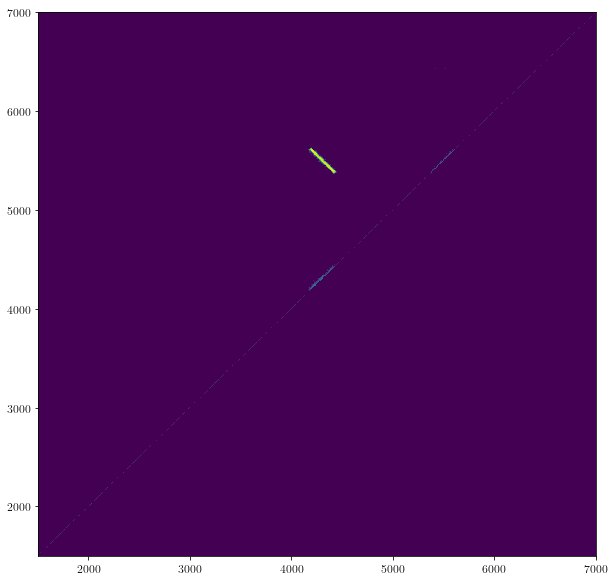

In [616]:
def pipico(tmin,tmax,binN,dataIndexes):
    hist = fh.histogram2d(data.loc[dataIndexes['index2']],data.loc[dataIndexes['index1']],range = [[tmin,tmax],[tmin,tmax]],bins = binN)

    hist = np.log(hist)
    hist[hist == -np.inf] = 0

    print(hist.max())

    dx = (tmax-tmin)/binN

    y, x = np.mgrid[slice(tmin, tmax + dx, dx),
    slice(tmin, tmax + dx, dx)]

    plt.pcolormesh(x,y,hist)
    plt.rcParams["figure.figsize"] = [10,10]
    plt.show()


pipico(1500,7000,1000,pairwise)


In [617]:
compList = pd.DataFrame(np.sort(np.append(cutIndexes['index1'].values,cutIndexes['index2'].values)),columns=['index0']).drop_duplicates().reset_index(drop=True)

Generates a dataframe with a complete list of the indexes of the datafile that were left over after the gating. The momentum and other physics calculations that just involve one particle will be done here, since you can populate the coincidence dataframe later with that info. 

(Man I love Pandas, those one-liners are so nice)

In [618]:
def dataPopulation(data,compList):
        
    temp = data.loc[compList['index0']][['x','y','tof','id','delay']]
    return temp


compList = dataPopulation(data,compList)
#compList['id'] = data.iloc[compList['index0'].values].id.reset_index(drop=True)

print(compList.iloc[:8])

        x      y       tof      id  delay
0  -2.937 -0.085  4422.907  5311.0    0.0
1   2.912  0.725  5405.539  5311.0    0.0
2   2.259  6.385  4425.823  5748.0    0.0
3  -0.806 -4.039  5403.323  5748.0    0.0
4  11.108 -3.324  4228.397  6320.0    0.0
5  -7.369  3.370  5597.941  6320.0    0.0
6 -10.681 -7.402  4208.101  6377.0    0.0
7   9.093  4.886  5598.898  6377.0    0.0


Fills in the data in the Dataframe of the post-cut detections

In [619]:
def getCenter(datalist):
    
    from helper import center_by_moments
    
    xmin = -60
    xmax = 60
    xbin = 150

    xy_hist = fh.histogram2d(datalist['x'],datalist['y'],range = [[xmin,xmax],[xmin,xmax]],bins = xbin)

    dx = (xmax- xmin)/xbin

    y_, x_ = np.mgrid[slice(xmin, xmax, dx),
               slice(xmin, xmax, dx)]

    x0,y0 = center_by_moments(x_[0],x_[0],xy_hist,True)
    
    return float(x0),float(y0)

x0, y0 = getCenter(compList)
print(x0,y0)

0.162804797860816 -0.19715139261098713
Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f28ac2152f0> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'        width_x : 13.2'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Arch Linux) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/home/matteo/.cache/matplotlib/tex.cache/091bce384b1724018e79fd1001879ef1.tex
LaTeX2e <2018-12-01>
(/usr/share/texmf-dist/tex/latex/base/article.cls
Document Class: article 2018/09/03 v1.4i Standard LaTeX document class
(/usr/share/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/share/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./091bce384b1724018e79fd1001879ef1.aux)
(/usr/share/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...00000}{20.000000}{\rmfamily         width_
                                                  x : 13.2}
No pages of output.
Transcript written on 091bce384b1724018e79fd1001879ef1.log.




<Figure size 720x720 with 0 Axes>

RuntimeError: latex was not able to process the following string:
b'        width_x : 13.2'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Arch Linux) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/home/matteo/.cache/matplotlib/tex.cache/091bce384b1724018e79fd1001879ef1.tex
LaTeX2e <2018-12-01>
(/usr/share/texmf-dist/tex/latex/base/article.cls
Document Class: article 2018/09/03 v1.4i Standard LaTeX document class
(/usr/share/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/share/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./091bce384b1724018e79fd1001879ef1.aux)
(/usr/share/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...00000}{20.000000}{\rmfamily         width_
                                                  x : 13.2}
No pages of output.
Transcript written on 091bce384b1724018e79fd1001879ef1.log.




<Figure size 3000x3000 with 1 Axes>

Gets the center of physics of the cut data.

In [620]:
from helper import fitEfield
from helper import GetZVelocity

E_field_new, ion_drift_length_new, t0_new = fitEfield()

print(t0_new)

ion_accel_length = 0.27

#in increasing order of mass (ie, mass of t1, mass of t2, etc)
#and the corisponding charge
#mass = [15,26]
mass = [14,27]
#mass = [13,27]

mass_si = [(m * 1.66056e-27) for m in mass]
charge = [1,1]


#ion_drift_length_new = 0.0118 #modify till 
#t0_new = 1251.5
t0_new = 1251.5
#t0_new = 1289

def apInd(string,ind):
    
    return string+str(ind)


<Parameter 't0', value=1270.3948332250093 +/- 2.44, bounds=[-inf:inf]>


The above cell sets up calculating the three componants of momenta. It and the two cells below are (I think) generalized for tripico as well.

Change mass and charge as needed. 

In [621]:
def filldata(compList,cutIndexes):
    
    addit = [cutIndexes]
    
    for ind in indList:
        
        temp0 = data.loc[cutIndexes[apInd('index',ind)]][['x','y','tof','delay']].reset_index(drop=True)
        temp0.columns = [apInd(col,ind) for col in temp0]
        addit.append(temp0)
  
    return pd.concat(addit, axis=1)
    

coincXYT = filldata(compList,cutIndexes)

  
print(coincXYT.iloc[:500])


           id  index1  index2      x1      y1      tof1  delay1      x2  \
0      5311.0       0       1  -2.937  -0.085  4422.907   0.000   2.912   
1      5748.0       2       3   2.259   6.385  4425.823   0.000  -0.806   
2      6320.0       4       5  11.108  -3.324  4228.397   0.000  -7.369   
3      6377.0       6       7 -10.681  -7.402  4208.101   0.000   9.093   
4      7842.0       8       9  17.588   2.075  4249.760   0.000 -12.153   
5      8140.0      10      11  12.589   7.283  4363.891   0.000  -8.260   
6     10741.0      12      13  -5.022  -0.279  4405.482   5.173   4.155   
7     12476.0      14      15   9.779   5.518  4412.718   5.173  -5.800   
8     16143.0      16      17  -8.684  -9.080  4388.413   5.173   6.926   
9     16947.0      18      19  -2.076  -2.461  4304.287   5.173  -0.665   
10    19129.0      20      21  -9.672   6.681  4219.538   5.173   8.282   
11    20211.0      22      23  -1.732 -18.423  4287.905   5.163   2.295   
12    20270.0      24    

In [622]:
def velocP(coincXYT):
    
    addit = [coincXYT]
    
    for ind in indList:      
        
        temp = pd.DataFrame()
        
        temp[apInd('tof0',ind)] = coincXYT[apInd('tof',ind)]-t0_new   
     
        temp[apInd('vx',ind)] = (coincXYT[apInd('x',ind)] - (x0+.322)) / (coincXYT[apInd('tof',ind)] - t0_new) * 1000000
        temp[apInd('vy',ind)] = (coincXYT[apInd('y',ind)] - (y0+.4)) / (coincXYT[apInd('tof',ind)] - t0_new) * 1000000
        temp[apInd('vz',ind)] = temp[apInd('tof0',ind)].apply(GetZVelocity,args=(mass[ind-1],charge[ind-1],E_field_new, ion_accel_length ,ion_drift_length_new))    
        
        temp[apInd('px',ind)] = mass_si[ind-1] * temp[apInd('vx',ind)] * 0.5 * 1e24
        temp[apInd('py',ind)] = mass_si[ind-1] * temp[apInd('vy',ind)] * 0.5 * 1e24
        temp[apInd('pz',ind)] = mass_si[ind-1] * temp[apInd('vz',ind)] * 0.5 * 1e24
    
        addit.append(temp)

    return(pd.concat(addit, axis=1))
    

completePop = velocP(coincXYT)

print(completePop.shape)
print(completePop.iloc[:10])

(556629, 25)
        id  index1  index2      x1     y1      tof1  delay1      x2     y2  \
0   5311.0       0       1  -2.937 -0.085  4422.907   0.000   2.912  0.725   
1   5748.0       2       3   2.259  6.385  4425.823   0.000  -0.806 -4.039   
2   6320.0       4       5  11.108 -3.324  4228.397   0.000  -7.369  3.370   
3   6377.0       6       7 -10.681 -7.402  4208.101   0.000   9.093  4.886   
4   7842.0       8       9  17.588  2.075  4249.760   0.000 -12.153 -0.960   
5   8140.0      10      11  12.589  7.283  4363.891   0.000  -8.260 -4.235   
6  10741.0      12      13  -5.022 -0.279  4405.482   5.173   4.155  1.272   
7  12476.0      14      15   9.779  5.518  4412.718   5.173  -5.800 -3.271   
8  16143.0      16      17  -8.684 -9.080  4388.413   5.173   6.926  5.564   
9  16947.0      18      19  -2.076 -2.461  4304.287   5.173  -0.665 -0.442   

       tof2    ...            px1        py1        pz1     tof02  \
0  5405.539    ...     -12.541684  -1.055030 -76.039840  41

Populates all three components of velocity, as well as the momentum for every detection selected with the cut, using the masses and charges given above.

In [623]:
completePop['pxsum'] = completePop['px1']+completePop['px2']
completePop['pysum'] = completePop['py1']+completePop['py2']
completePop['pzsum'] = completePop['pz1']+completePop['pz2']

(4.7353300896542985, 95.55215304495243)


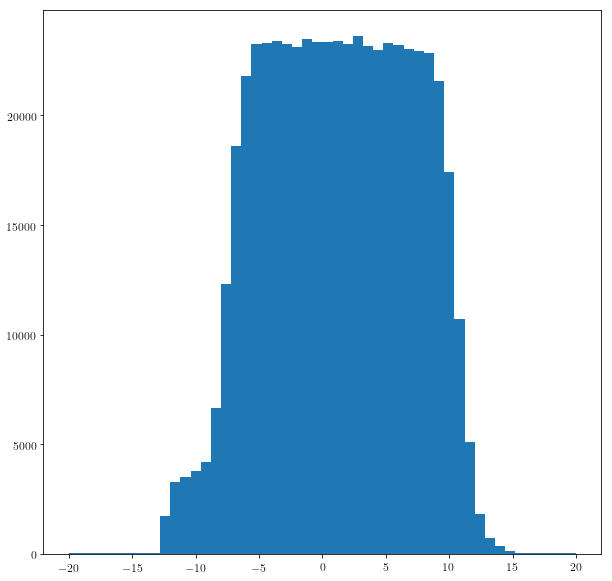

In [624]:
pCur = completePop['pzsum']
plt.hist(pCur,bins=50,range=[-20,20])
print(norm.fit(pCur))
plt.show()

In [625]:
plist = [col for col in completePop if col.startswith('p')]
plist_si = [p+'_si' for p in plist]
#print(plist,plist_si)

for p_si in plist_si:
    
    completePop[p_si] = completePop[p_si[:-3]] * 2e-24 


In [626]:
completePop['KE1_ev'] = (completePop['px1_si']**2 + completePop['py1_si']**2 + completePop['pz1_si']**2) /(2*mass_si[0]) *6.242e18
completePop['KE2_ev'] = (completePop['px2_si']**2 + completePop['py2_si']**2 + completePop['pz2_si']**2) /(2*mass_si[1]) *6.242e18

In [627]:
completePop['KER_ev'] = completePop['KE1_ev'] + completePop['KE2_ev']

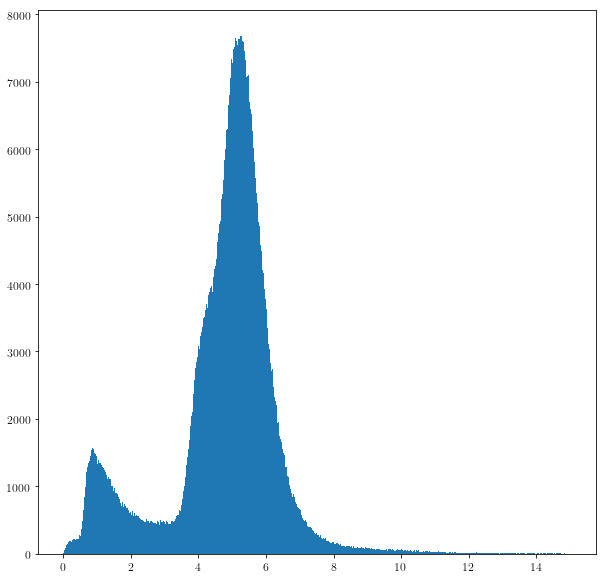

In [628]:
plt.hist(completePop.KER_ev,bins=500,range=[0,15])
plt.show()

In [629]:
completePop['ptot'] = (completePop['pxsum']**2 + completePop['pysum']**2 + completePop['pzsum']**2)**.5

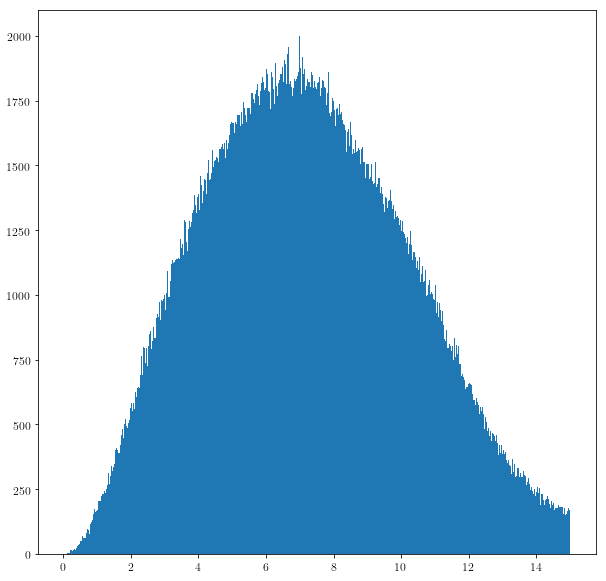

In [630]:
plt.hist(completePop.ptot,bins=500,range=[0,15])
plt.show()

(556629, 41)


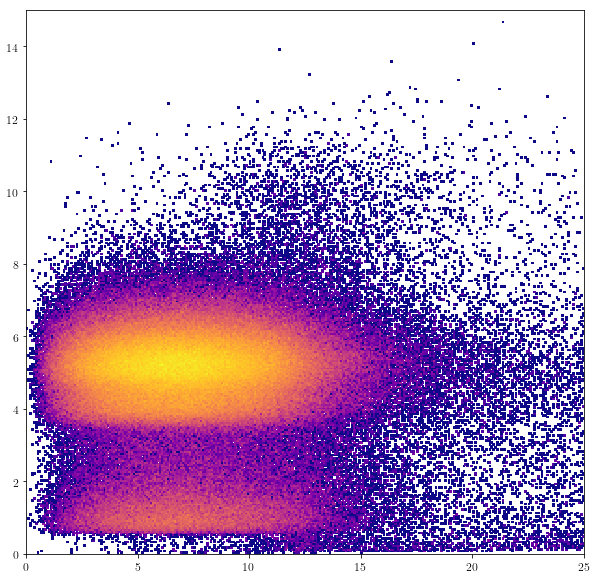

In [631]:
print(completePop.shape)
plt.hist2d(completePop.ptot,completePop.KER_ev,bins=300,norm=mpl.colors.LogNorm(),range=[[0,25],[0,15]],cmap=mpl.cm.plasma)
plt.show()

In [632]:
keCut = completePop[completePop['ptot'] < 17]
print(keCut.shape[0]/completePop.shape[0])

0.9212832964146676


(556629, 41)


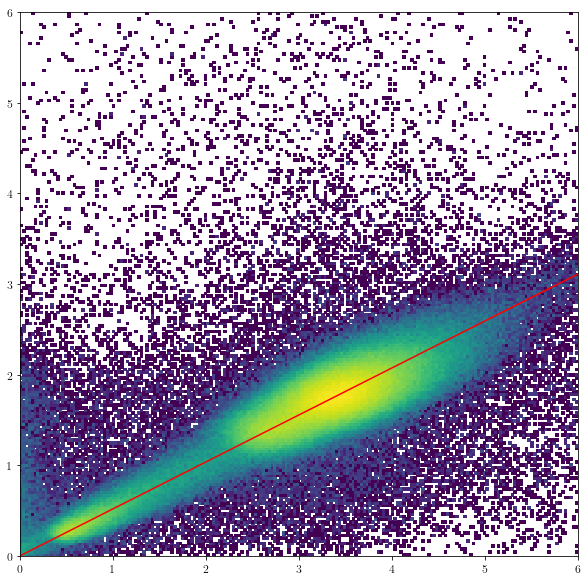

In [633]:
print(completePop.shape)
xx_ = np.arange(0,6,.01)
yy_ = xx_*(mass[0]/mass[1])

plt.hist2d(completePop.KE1_ev,completePop.KE2_ev,bins=200,norm=mpl.colors.LogNorm(),range=[[0,6],[0,6]])
plt.plot(xx_,yy_,'r')
plt.show()

[6281.4419955   201.95901205 5556.34588342]
[239.28036311  12.03931369 256.02516116]
[6330.13820582  170.71156113 5519.53523   ]
[326.5481142   12.18225448 342.72066857]


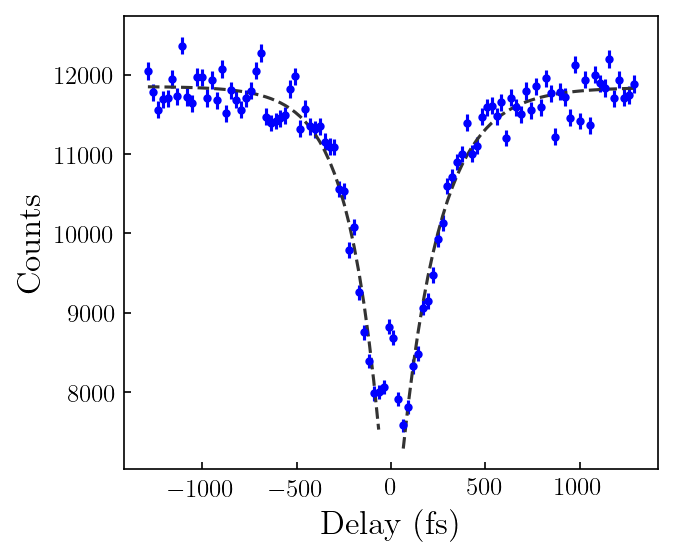

In [634]:
from scipy.optimize import curve_fit
from matplotlib import rc


d_min = -1300 #(fs)
d_max = 1300

def VtoDelay(v_min,v_max,d_min,d_max,vList):
    
    m = (d_max-d_min)/(v_max-v_min)
    
    delay = m*(vList-((v_max+v_min)/2))  
    return delay


compList = compList[compList['delay']>0.1]
 
compList['delay_fs'] = VtoDelay(compList.delay.min(),compList.delay.max(),d_min,d_max,compList['delay'])


bn = 100
bwidth = (d_max-d_min)/bn
hoist = np.histogram(compList['delay_fs'],bins=bn)

ex = hoist[1][:-1]+bwidth/2
wy = hoist[0]


nhmP = wy[int(bn/2)+2:]
nhxP = ex[int(bn/2)+2:]

nhmN = wy[:int(bn/2)-2]
nhxN = ex[:int(bn/2)-2]


def fitfunP(t,a,t0,c):
    return a*(1-np.exp(-t/t0))+c

def fitfunN(t,a,t0,c):
    return a*(1-np.exp(t/t0))+c
    
poptP,pcovP = curve_fit(fitfunP ,nhxP ,nhmP,p0=[1.15434327e+05,900,1000],sigma=np.sqrt(np.absolute(nhmP)))
poptN,pcovN = curve_fit(fitfunN ,nhxN ,nhmN,p0=[1.15434327e+05,900,1000],sigma=np.sqrt(np.absolute(nhmN)))


perrP = np.sqrt(np.diag(pcovP))
perrN = np.sqrt(np.diag(pcovN))

print(poptP)
print(perrP)

print(poptN)
print(perrN)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')

fig = plt.figure(figsize=(4.6, 4),dpi=150)
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Delay (fs)',fontsize=16)
ax.set_ylabel('Counts',fontsize=16)
ax.tick_params('both',direction='in')



plt.errorbar(ex,wy,yerr=np.sqrt(np.absolute(wy)),fmt = 'b.')
plt.plot(nhxP,fitfunP(nhxP,*poptP),color='0.20', ls='dashed')
plt.plot(nhxN,fitfunN(nhxN,*poptN),color='0.20', ls='dashed')

plt.savefig('delay-yeald-SHM.png')
plt.show()




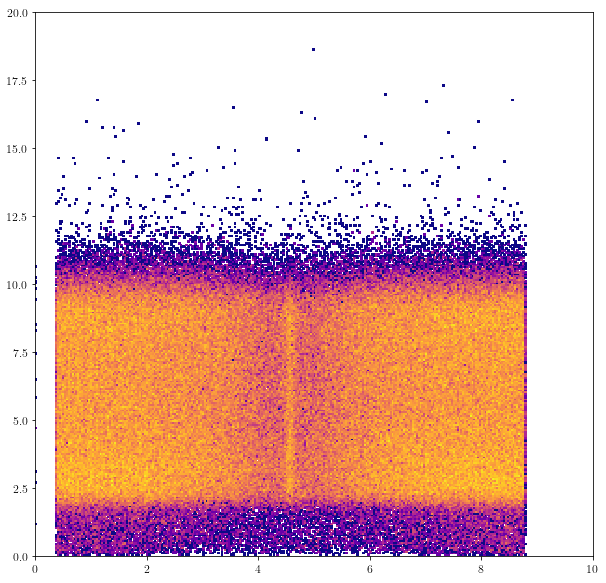

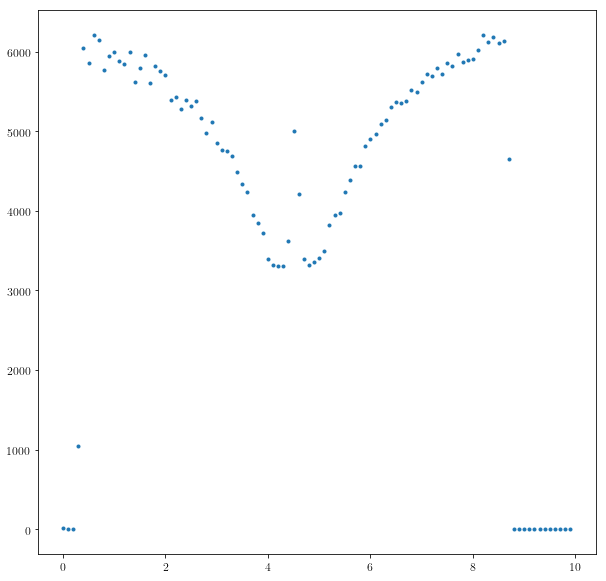

In [590]:
plt.hist2d(keCut.delay1,keCut.KER_ev,bins=300,range= [[0, 10], [0, 20]],norm=mpl.colors.LogNorm(),cmap=mpl.cm.plasma)
plt.show()

hist_ = fh.histogram2d(keCut.KER_ev,keCut.delay1,range= [[0,30],[0,10]],bins = 100)



plt.plot(np.arange(0,10,.1),list(hist_.sum(axis=0)),'.')
plt.show()

In [334]:
kECut = completePop[completePop['KER_ev'] < 3.2]


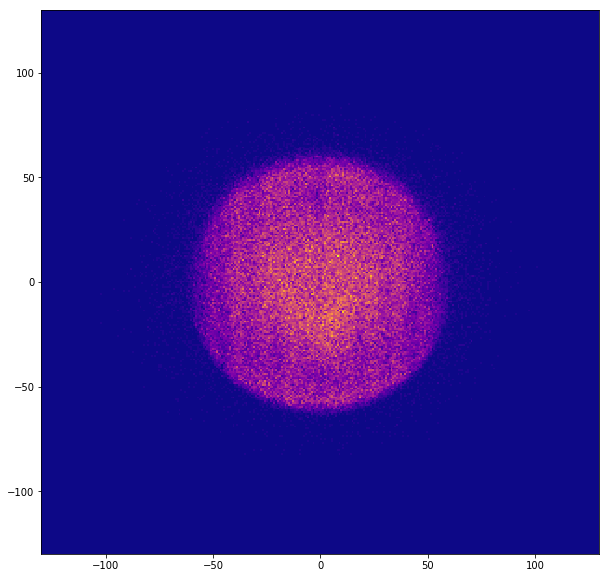

In [335]:
pX = pd.concat([kECut['px1'],kECut['px2']])
pY = pd.concat([kECut['py1'],kECut['py2']])
pZ = pd.concat([kECut['pz1'],kECut['pz2']])


#plt.hist2d(kECut.pz1,kECut.px1+kECut.py1,bins=300,range=[[-100,100],[-140,120]])
plt.hist2d(pX,(pY+pZ)/np.sqrt(2),bins=300,range=[[-130,130],[-130,130]],cmap=mpl.cm.plasma)
plt.show()

In [336]:
from helper import cosineAnglefromMomenta

kECut['cos'] = cosineAnglefromMomenta(kECut['px1'],kECut['py1'],kECut['pz1'],kECut['px2'],kECut['py2'],kECut['pz2'])



/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [337]:
kECut['p2tot'] = (kECut['px2']**2+kECut['py2']**2+kECut['pz2']**2)**.5
kECut['newt_x'] = kECut['cos']*kECut['p2tot']
kECut['newt_y'] = (kECut['p2tot']**2-kECut['newt_x']**2)**.5
print(kECut)

                 id  index1  index2      x1      y1      tof1  delay1      x2  \
5            6490.0      10      11  -6.702   3.736  4269.742   0.000   5.453   
8           10839.0      16      17  12.565   9.657  4270.755   5.173  -7.853   
21          41761.0      42      43   8.134  -3.995  4208.444   5.121  -0.076   
24          49886.0      48      49   5.237  -8.148  4311.991   5.121  -2.533   
30          58775.0      60      61  -7.886  -0.742  4220.094   5.104   8.470   
31          62995.0      62      63   3.831   2.328  4305.487   5.088  -2.628   
40          93150.0      80      81  -8.102 -12.320  4282.878   5.037   4.189   
44          98945.0      85      86   0.171  -2.755  4186.225   5.037  -0.556   
45          99430.0      87      88  -3.704 -12.918  4284.316   5.037   3.476   
53         116900.0     103     104  -4.442  13.327  4226.310   4.993   3.888   
56         126211.0     109     110   9.520   7.479  4294.588   4.977  -6.285   
59         128854.0     115 

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

In [338]:
import matplotlib.animation as animation
from IPython.display import HTML

step_n = 5
max_delay = 1300

step_size = (8.776-4.6)/step_n
delay_step= max_delay/step_n

def newt_getslice(n):

    cent = 4.6
    maxi = 8.778 

    lowp = cent+ step_size*n
    higp = cent+ step_size*(n+1)
    
    lowm = cent- step_size*n
    higm = cent- step_size*(n+1)
    
    x = pd.concat([kECut['newt_x'][(kECut['delay1']> lowp)&(kECut['delay1']<higp)],kECut['newt_x'][(kECut['delay1']> higm)&(kECut['delay1']<lowm)]])
    y = pd.concat([kECut['newt_y'][(kECut['delay1']> lowp)&(kECut['delay1']<higp)],kECut['newt_y'][(kECut['delay1']> higm)&(kECut['delay1']<lowm)]])

    plt.hist2d(x,y,bins=300,cmap=mpl.cm.plasma,norm=mpl.colors.LogNorm(),range=[[-90,90],[0,100]])
    plt.title(str(int(delay_step*n))+' to '+str(int(delay_step*(n+1)))+' fs')
    plt.ylabel('Momentum (AU)')
    plt.xlabel('Momentum (AU)')
    plt.savefig('tmp'+str(n)+'.png')
    plt.close()

for i in range(step_n):
    
    newt_getslice(i)
